## Multi - Agent [Langgraph]

##### Load Environment variables

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
tavily_api_key = os.getenv('TAVILY_API_KEY')
model_id = os.getenv('MODEL_ID')
aws_region = os.getenv('AWS_REGION')
bedrock_kb_id = os.getenv('BEDROCK_KB_ID')

##### Model

In [ ]:
from langchain_aws import ChatBedrock
model = ChatBedrock(model=model_id)

##### Memory

In [2]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

In [3]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

##### Agent 1

In [4]:
from langgraph.prebuilt import create_react_agent

from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing import Annotated

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    repl = PythonREPL()

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## chart agent
chart_agent = create_react_agent(
    model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

##### Agent 2

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
import os

tavily_tool = TavilySearchResults(max_results=5)

# Research agent and node
research_agent = create_react_agent(
    model,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [9]:
from langchain_core.messages import BaseMessage, HumanMessage

query = "First, get the UK's GDP over the past 5 years, then make a line chart of it. "

ans = research_agent.invoke({"messages": [HumanMessage(content=query)]})
ans['messages'][-1]

AIMessage(content='Based on the search results, I\'ve found the UK\'s GDP data for the past 5 years (2019-2023). Here are the values in billions of USD:\n\n2019: $2,851.41B\n2020: $2,697.81B\n2021: $3,141.51B\n2022: $3,088.84B\n2023: $3,340.03B\n\nI don\'t have the ability to create charts, but I\'ll pass this data to my chart generator colleague who can create a line chart with this information. They should create a line chart with:\n- Years (2019-2023) on the x-axis\n- GDP values in billions of USD on the y-axis\n- Title should be "UK GDP 2019-2023"\n- Y-axis should start at around $2,500B to better show the variations\n\nOver to my chart generator colleague to create the visualization!', additional_kwargs={'usage': {'prompt_tokens': 2404, 'completion_tokens': 210, 'total_tokens': 2614}, 'stop_reason': 'end_turn', 'model_id': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0'}, response_metadata={'usage': {'prompt_tokens': 2404, 'completion_tokens': 210, 'total_tokens': 2614}, 'stop_reas

##### Wrap Agent in Langgraph Node

In [10]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.types import Command
from langgraph.graph import MessagesState, StateGraph, START, END

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [11]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

##### Build the graph

In [12]:
workflow = StateGraph(MessagesState)

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")

graph = workflow.compile()


##### View the graph

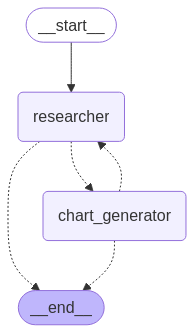

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

##### invoke the agent

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='0be4aa11-c83c-4dee-b041-ef4f93a1cd98'), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 555, 'completion_tokens': 101, 'total_tokens': 656}, 'stop_reason': 'tool_use', 'model_id': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0'}, response_metadata={'usage': {'prompt_tokens': 555, 'completion_tokens': 101, 'total_tokens': 656}, 'stop_reason': 'tool_use', 'model_id': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='run-94e12553-35b4-4db8-a12a-3c0cdfb44c3d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP annual data past 5 years 2019-2023'}, 'id': 'toolu_bdrk_019Nash253LrJ3inZP3APA2G', 'type': 'tool_call'}], usage_metadata={'input_tokens': 555, 'output_tokens': 101, 'total_tokens': 656}), ToolMessage(content='[{"url": "https://

Python REPL can execute arbitrary code. Use with caution.


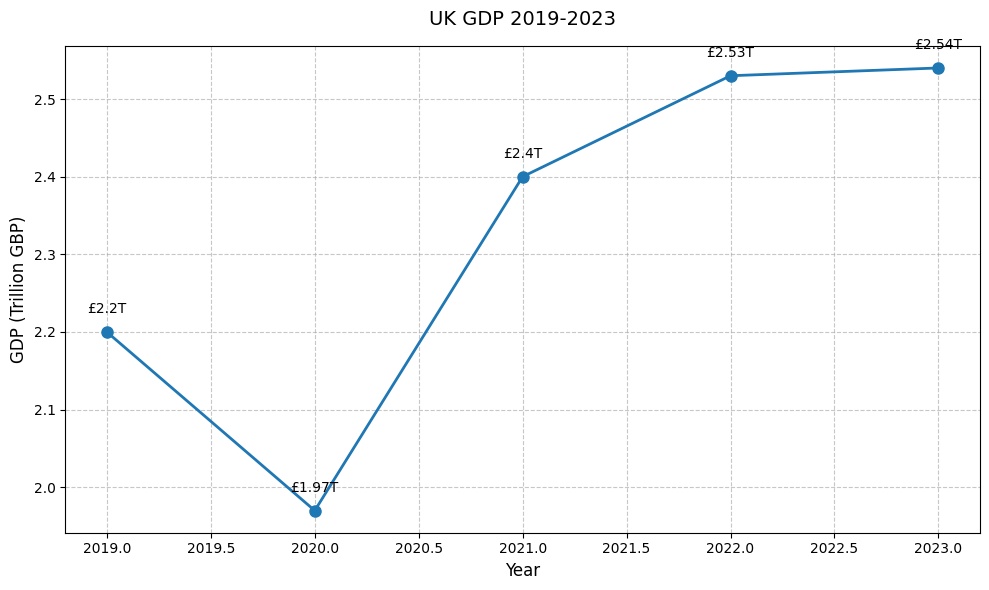

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='0be4aa11-c83c-4dee-b041-ef4f93a1cd98'), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 555, 'completion_tokens': 101, 'total_tokens': 656}, 'stop_reason': 'tool_use', 'model_id': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0'}, response_metadata={'usage': {'prompt_tokens': 555, 'completion_tokens': 101, 'total_tokens': 656}, 'stop_reason': 'tool_use', 'model_id': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='run-94e12553-35b4-4db8-a12a-3c0cdfb44c3d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP annual data past 5 years 2019-2023'}, 'id': 'toolu_bdrk_019Nash253LrJ3inZP3APA2G', 'type': 'tool_call'}], usage_metadata={'input_tokens': 555, 'output_tokens': 101, 'total_tokens': 656}), ToolMessage(content='[{"url": "htt

In [11]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")